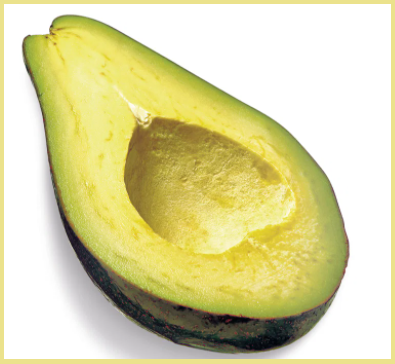

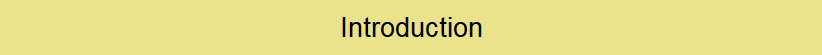

In this notebook, i am going to predict avocados prices using some regression models (Linear Regression, Decision Tree, Random Forest, Support Vector Machine and XGBoost). To evaluate each model, i will split the data 75% into train set and 25% into validation/test set, and than get all the scores: train, R², MAE, MSE and RMSE. But first, an EDA (Exploratory Data Analysis) will be done.

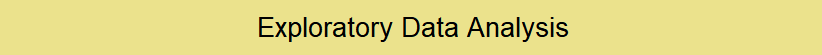

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

SEED = 42

In [ ]:
# Loading data
df = pd.read_csv("/kaggle/input/avocado-prices/avocado.csv")
df.head(8)

* **Date** - The date of the observation.
* **AveragePrice** - The average price of a single avocado.
* **Total Volume** - Total number of avocados sold.
* **4046** - Total number of avocados with PLU 4046 sold.
* **4225** - Total number of avocados with PLU 4225 sold.
* **4770** - Total number of avocados with PLU 4770 sold.
* **Total Bags** =  **Small Bags** + **Large Bags** + **XLarge Bags**	
* **type** - The avocado type.
* **year** - The year of the observation.
* **region** - The region of the observation.

In [ ]:
df.info()

<font size="4">Missing Values</font>

As we can see from data frame info, there are no missing values.

In [ ]:
if df.isnull().sum().any() == False:
    print("there are no missing values")
else:
    print("there are something wrong here")

<font size="4">Duplicate Rows</font>

Before check for duplicate rows, we need to drop the "Unnamed: 0" column.

In [ ]:
# Dropping "Unnamed: 0" column
df = df.drop(["Unnamed: 0"], axis = 1)

# Checking for duplicate rows
print("number of duplicate rows: ", df.duplicated().sum())

<font size="4">Columns</font>

Let's extract only the month in "Date" column (we already have a "year" column), rename it and create a new column for them, and than drop the "Date" column.

In [ ]:
df["month"] = np.nan
months_dict = {"Jan" : "01",
               "Feb" : "02", 
               "Mar" : "03",
               "Apr" : "04",
               "May" : "05",
               "Jun" : "06",
               "Jul" : "07",
               "Aug" : "08",
               "Sep" : "09",
               "Oct" : "10",
               "Nov" : "11",
               "Dec" : "12"}

months_key_list = list(months_dict.keys())
months_value_list = list(months_dict.values())

for index in range(df.shape[0]):
    date = df.loc[index, "Date"]
    month = date.split("-")[1]
    i = months_value_list.index(month)
    df.loc[index, "month"] = months_key_list[i]
    
# Checking if the values are correct
df["month"].unique()

In [ ]:
# Dropping "Date" column
df = df.drop(["Date"], axis = 1)

<font size="4">Visualizing Data</font>

In [ ]:
for position in range(len(df["year"].values)):
    df.loc[position, "year"] = str(df.loc[position, "year"])

In [ ]:
# Numerical data
df.describe().T

In [ ]:
# Categorical data
df.describe(include = "O").T

In [ ]:
sns.set_style("whitegrid")

df_type = df["type"].value_counts()

plt.figure(figsize = (7, 7))
plt.pie(data = df_type, x = df_type.values, labels = df_type.index, autopct = "%.2f%%", pctdistance = 0.75, startangle = 90, colors = ["green", "lime"])
circle = plt.Circle(xy = (0, 0), radius = 0.55, facecolor = 'white')
plt.gca().add_artist(circle)
plt.title("% of Each Avocado Type", size = 16)
plt.show()

As we can see, there are basically the same quantity of conventional and organic avocados. In numbers:

In [ ]:
print("total number of conventinal avocados: {0}\ntotal number of organic avocados: {1}".format(df["type"].value_counts()["conventional"], df["type"].value_counts()["organic"]))

In [ ]:
plt.figure(figsize = (8, 7))
sns.histplot(data = df, x = "AveragePrice", hue = "type", kde = True, palette = ["green", "lime"])
plt.title("Distribution of Average Prices", size = 16)
plt.show()

In [ ]:
df_conventional = df.loc[df["type"] == "conventional"].copy()
df_region = df_conventional.groupby(["region"])[["AveragePrice"]].mean().sort_values(by = "AveragePrice", ascending = False).copy()

plt.figure(figsize = (8, 14))
sns.barplot(data = df_region, x = "AveragePrice", y = df_region.index, color = "green")
plt.title("Most Expensive Avocados (Conventional)", size = 16)
plt.show()

In [ ]:
df_organic = df.loc[df["type"] == "organic"].copy()
df_region = df_organic.groupby(["region"])[["AveragePrice"]].mean().sort_values(by = "AveragePrice", ascending = False).copy()

plt.figure(figsize = (8, 14))
sns.barplot(data = df_region, x = "AveragePrice", y = df_region.index, color = "lime")
plt.title("Most Expensive Avocados (Organic)", size = 16)
plt.show()

For this part, the year of 2018 will be removed, because there are only few observations of price in this year.

In [ ]:
df_visualization = df.loc[df["year"] != "2018"].copy()

# Putting months in order for a better visualization
df_visualization["month"] = pd.Categorical(df_visualization["month"], categories=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], ordered = True)

In [ ]:
plt.figure(figsize = (9, 7))
sns.lineplot(data = df_visualization, x = "year", y = "AveragePrice", hue = "type", palette = ["green", "lime"])
plt.title("Year x Average Price | for Each Avocado Type", size = 16)
plt.show()

In [ ]:
plt.figure(figsize = (9, 7))
sns.lineplot(data = df_visualization, x = "year", y = "Total Volume", hue = "type", palette = ["green", "lime"])
plt.title("Year x Total Volume | for Each Avocado Type", size = 16)
plt.show()

In [ ]:
plt.figure(figsize = (9, 7))
sns.lineplot(data = df_visualization.loc[df["year"] == "2015"], x = "month", y = "AveragePrice", hue = "type", palette = ["green", "lime"])
plt.title("Month x Average Price | for Each Avocado Type (2015)", size = 16)
plt.show()

In [ ]:
plt.figure(figsize = (9, 7))
sns.lineplot(data = df_visualization.loc[df["year"] == "2016"], x = "month", y = "AveragePrice", hue = "type", palette = ["green", "lime"])
plt.title("Month x Average Price | for Each Avocado Type (2016)", size = 16)
plt.show()

In [ ]:
plt.figure(figsize = (9, 7))
sns.lineplot(data = df_visualization.loc[df["year"] == "2017"], x = "month", y = "AveragePrice", hue = "type", palette = ["green", "lime"])
plt.title("Month x Average Price | for Each Avocado Type (2017)", size = 16)
plt.show()

Now, seeing all this information together (from the last three graphs):

In [ ]:
plt.figure(figsize = (9, 7))
sns.lineplot(data = df_visualization.loc[df["type"] == "conventional"], x = "month", y = "AveragePrice", hue = "year", palette = ["springgreen", "seagreen", "darkgreen"])
plt.title("Month x Average Price | for Each Year (Conventional)", size = 16)
plt.show()

In [ ]:
plt.figure(figsize = (9, 7))
sns.lineplot(data = df_visualization.loc[df["type"] == "organic"], x = "month", y = "AveragePrice", hue = "year", palette = ["springgreen", "seagreen", "darkgreen"])
plt.title("Month x Average Price | for Each Year (Organic)", size = 16)
plt.show()

<font size="4">Preparing the Data</font>

In [ ]:
X = df.drop(["AveragePrice"], axis = 1).copy()
y = df["AveragePrice"].copy()

# Dummie variables
X = pd.get_dummies(data = X, columns = ["type", "region", "month", "year"], prefix = ["type", "region", "month", "year"], drop_first = True)

# Scaling tha data
ss = StandardScaler()
X = ss.fit_transform(X)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, shuffle = True)

In [ ]:
model_scores = {"train" : [],
                "test" : [],
                "mae" : [],
                "mse" : [],
                "rmse" : []}

def get_results(clf):
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    model_scores["train"].append(train_score)
    pred = clf.predict(X_test)
    test_score = clf.score(X_test, y_test)
    model_scores["test"].append(test_score)
    mae = mean_absolute_error(pred, y_test)
    model_scores["mae"].append(mae)
    mse = mean_squared_error(pred, y_test)
    model_scores["mse"].append(mse)
    rmse = np.sqrt(mse)
    model_scores["rmse"].append(rmse)
    print("train score: {0:.4f}\nR2 score: {1:.4f}\nMAE: {2:.4f}\nMSE: {3:.4f}\nRMSE: {4:.4f}".format(train_score, test_score, mae, mse, rmse))
    plt.figure(figsize = (13, 6))
    plt.subplot(1, 2, 1)
    plt.title("y_true x y_pred", size = 14)
    plt.scatter(y_test, pred, color = "mediumseagreen")
    plt.xlabel("y_true")
    plt.ylabel("y_pred")
    plt.subplot(1, 2, 2)
    plt.title("Residuals (y_true - y_pred)", size = 14)
    sns.histplot((y_test-pred), kde = True, color = "green")
    plt.show()

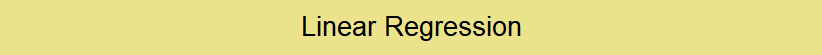

In [ ]:
lr = LinearRegression()
print("Linear Regression\n")
get_results(lr)

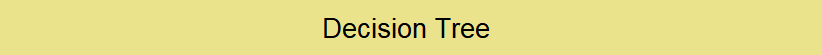

In [ ]:
dtr = DecisionTreeRegressor(random_state = SEED)
print("Decision Tree\n")
get_results(dtr)

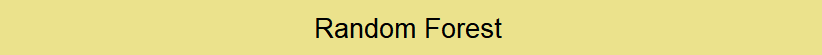

In [ ]:
rfr = RandomForestRegressor(random_state = SEED)
print("Random Forest\n")
get_results(rfr)

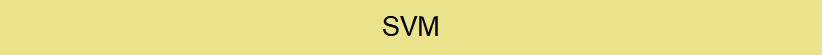

In [ ]:
svr = SVR()
print("Support Vector Machine (SVM)\n")
get_results(svr)

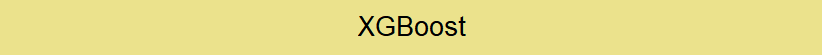

In [ ]:
xgbr = XGBRegressor(random_state = SEED)
print("XGBoost\n")
get_results(xgbr)

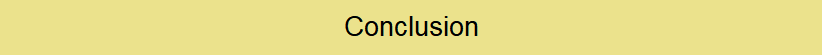

In [ ]:
df_results = pd.DataFrame(data = model_scores, index = ["Linear Regression", "Decision Tree", "Random Forest", "SVM", "XGBoost"])
models = ["Linear Regression", "Decision Tree", "Random Forest", "SVM", "XGBoost"]
plt.figure(figsize = (7, 4))
sns.barplot(data = df_results, x = "test", y = models, color = "seagreen")
sns.barplot(data = df_results, x = "train", y = models, color = "seagreen", alpha = 0.1)
plt.title("Test Score (R²)", size = 16)
plt.show()

In [ ]:
plt.figure(figsize = (7, 4))
sns.barplot(data = df_results, x = "mae", y = models, color = "seagreen")
plt.title("Mean Absolute Error (MAE)", size = 16)
plt.show()

In [ ]:
plt.figure(figsize = (7, 4))
sns.barplot(data = df_results, x = "mse", y = models, color = "seagreen")
plt.title("Mean Squared Error (MSE)", size = 16)
plt.show()

In [ ]:
plt.figure(figsize = (7, 4))
sns.barplot(data = df_results, x = "rmse", y = models, color = "seagreen")
plt.title("Root Mean Squared Error (RMSE)", size = 16)
plt.show()

While Linear Regression model underffited (the model is to simple to handle all the informations), the Decision Tree model overffited (the model has adapted too much to the data, prun the tree it is one good way to prevent this).

XGBoost seems to be the best model in this case (default hyperparameters were used).